In [1]:
import os
import random
from typing import Tuple

import torch
import matplotlib.pyplot as plt
from dotenv import load_dotenv
from datasets import load_dataset
from torchvision import transforms
from torch.utils.data import DataLoader
from PIL import Image, ImageFilter, ImageOps
from timm.models.vision_transformer import vit_small_patch16_224

/Users/ericmonzon/mambaforge/envs/pytorch/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
load_dotenv(os.path.join("..", ".env"))

hf_token = os.getenv("HF_TOKEN")

In [7]:
class Augment:
    
    """
    Takes in an image and creates two global crops 
    with a configurable number of local crops.
    """

    def __init__(
        self, 
        global_scale: Tuple[float],
        local_scale: Tuple[float],
        num_local_crops: int,
        ):

        normalize = transforms.Compose([
            transforms.ToTensor(),
            # transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
        ])

        self.global_transform1 = transforms.Compose([
            transforms.RandomResizedCrop(224, scale=global_scale, interpolation=Image.BICUBIC),
            transforms.RandomHorizontalFlip(p=0.5),
            *self._color_distortion(),
            GaussianBlur(p=1.0),
            normalize
        ])

        self.global_transform2 = transforms.Compose([
            transforms.RandomResizedCrop(224, scale=global_scale, interpolation=Image.BICUBIC),
            transforms.RandomHorizontalFlip(p=0.5),
            *self._color_distortion(),
            GaussianBlur(p=0.1),
            Solarization(p=0.2),
            normalize
        ])

        self.local_transform = transforms.Compose([
            transforms.RandomResizedCrop(96, scale=local_scale, interpolation=Image.BICUBIC),
            transforms.RandomHorizontalFlip(p=0.5),
            *self._color_distortion(),
            GaussianBlur(p=0.5),
            normalize
        ])

        self.num_local_crops = num_local_crops

    def _color_distortion(self):
        """
        Functions to apply color distortion to the images.
        """

        color_jitter = transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.2, hue=0.1)
        
        rnd_color_jitter = transforms.RandomApply([color_jitter], p=0.8)
        rnd_gray = transforms.RandomGrayscale(p=0.2)
        
        return [rnd_color_jitter, rnd_gray]
    
    def __call__(self, img: Image):
        global_crops = [self.global_transform1(img), self.global_transform2(img)]
        local_crops = [self.local_transform(img) for _ in range(self.num_local_crops)]

        crops = {
            "global_crops": global_crops,
            "local_crops": local_crops
        }

        return crops


class GaussianBlur(object):
    """
    Apply Gaussian Blur to the PIL image.
    Taken from https://github.com/facebookresearch/dino/blob/main/utils.py
    """
    
    def __init__(self, p=0.5, radius_min=0.1, radius_max=2.0):
        self.prob = p
        self.radius_min = radius_min
        self.radius_max = radius_max

    def __call__(self, img):
        do_it = random.random() <= self.prob
        if not do_it:
            return img

        return img.filter(
            ImageFilter.GaussianBlur(
                radius=random.uniform(self.radius_min, self.radius_max)
            )
        )


class Solarization(object):
    """
    Apply Solarization to the PIL image.
    Taken from https://github.com/facebookresearch/dino/blob/main/utils.py
    """
    
    def __init__(self, p):
        self.p = p

    def __call__(self, img):
        if random.random() < self.p:
            return ImageOps.solarize(img)
        else:
            return img

In [8]:
global_scale = (0.4, 1.0)
local_scale = (0.05, 0.4)
num_local_crops = 2

augment = Augment(global_scale, local_scale, num_local_crops)

def transform(batch):
    batch["image"] = [augment(img) for img in batch["image"]]
    return batch

In [9]:
cache_dir = os.path.join("..", "data")
os.environ["HF_HOME"] = cache_dir

dataset = load_dataset("ILSVRC/imagenet-1k", cache_dir=cache_dir, split="train")
dataset.set_transform(lambda x: transform(x))

In [10]:
data_loader = DataLoader(dataset, batch_size=8, shuffle=True)

batch = next(iter(data_loader))

In [11]:
model = vit_small_patch16_224(dynamic_img_size=True)

model

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 384, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=384, out_features=1152, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=384, out_features=384, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=384, out_features=1536, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (norm): Identity(

tensor(146)


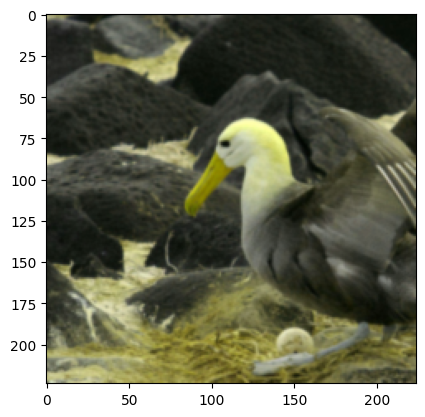

In [33]:
idx = 6

print(batch["label"][idx])
plt.imshow(batch["image"]["global_crops"][0][idx].squeeze().permute(1,2,0).numpy())

plt.show()

tensor(146)


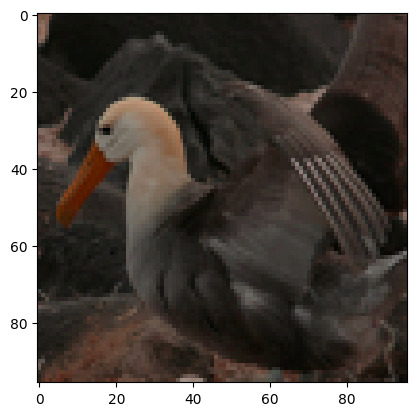

In [30]:
print(batch["label"][idx])
plt.imshow(batch["image"]["local_crops"][1][idx].squeeze().permute(1,2,0).numpy())

plt.show()

In [36]:
print(batch["image"]["global_crops"][0].shape)

model(batch["image"]["global_crops"][0])

torch.Size([8, 3, 224, 224])


tensor([[-0.1775,  0.7509,  0.3389,  ...,  0.1098,  0.0420,  0.3520],
        [-0.0528,  0.6809,  0.1897,  ...,  0.0863, -0.1378,  0.4085],
        [-0.2010,  0.6806,  0.3479,  ...,  0.1351,  0.1541,  0.3176],
        ...,
        [-0.1933,  0.8299,  0.3175,  ...,  0.1117,  0.0055,  0.3395],
        [-0.1238,  0.8957,  0.1438,  ...,  0.1350, -0.0771,  0.2982],
        [-0.1044,  0.5706,  0.4296,  ...,  0.1405,  0.0246,  0.4380]],
       grad_fn=<AddmmBackward0>)

In [37]:
print(batch["image"]["local_crops"][1].shape)

model(batch["image"]["local_crops"][1])

torch.Size([8, 3, 96, 96])


tensor([[-0.1430,  0.5518,  0.4389,  ...,  0.1464,  0.1072,  0.4359],
        [-0.0943,  0.7893,  0.1174,  ...,  0.1034, -0.1106,  0.3401],
        [-0.1818,  0.6645,  0.3857,  ...,  0.1282,  0.0513,  0.4167],
        ...,
        [-0.1995,  0.7486,  0.3520,  ...,  0.1092,  0.0424,  0.3844],
        [-0.0785,  0.9421,  0.1425,  ...,  0.1350, -0.0851,  0.3356],
        [-0.1628,  0.6622,  0.3710,  ...,  0.1044, -0.0069,  0.4448]],
       grad_fn=<AddmmBackward0>)